In [1]:
# ! pip install kaggle
# ! mkdir -p ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json



In [2]:
# ! kaggle datasets download -d shubhambathwal/flight-price-prediction

In [3]:
# from zipfile import ZipFile
# filename = 'flight-price-prediction.zip'
# with ZipFile(filename, 'r') as zip:
#     zip.extractall()
#     print('Done!')

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [6]:
#dropping the unnamed: 0 column
df = df.drop(columns=['Unnamed: 0'])

In [7]:
# quick information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [8]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [9]:
df.corr().T

,duration,days_left,price
duration,1.000000,-0.039157,0.204222
days_left,-0.039157,1.000000,-0.091949
price,0.204222,-0.091949,1.000000


In [10]:
df.shape

(300153, 11)

In [11]:
df1=df.groupby(['flight','airline'],as_index=False).count()
df1.airline.value_counts()

Indigo       704
Air_India    218
GO_FIRST     205
SpiceJet     186
Vistara      133
AirAsia      115
Name: airline, dtype: int64

[Text(0, 0, 'Indigo'),
 Text(1, 0, 'Air_India'),
 Text(2, 0, 'GO_FIRST'),
 Text(3, 0, 'SpiceJet'),
 Text(4, 0, 'Vistara'),
 Text(5, 0, 'AirAsia')]

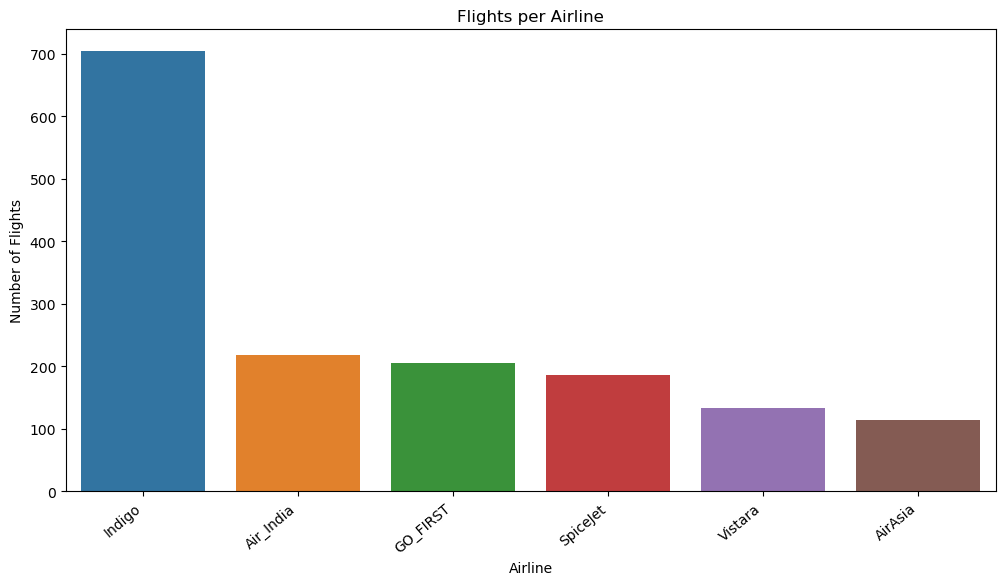

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
airline_counts = df1.airline.value_counts()
ax = sns.barplot(x=airline_counts.index, y=airline_counts.values)

ax.set(xlabel='Airline', 
       ylabel='Number of Flights',
       title='Flights per Airline')
       

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [13]:
df2=df.groupby(['flight','airline','class'],as_index=False).count()
df2['class'].value_counts()

Economy     1560
Business     295
Name: class, dtype: int64

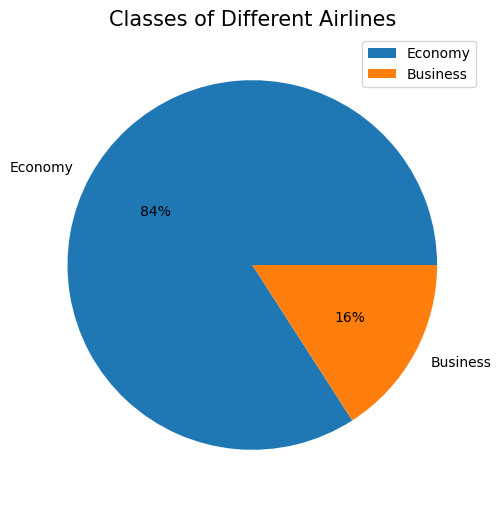

In [30]:
# bar chart
plt.figure(figsize=(8,6))
plt.pie(df2['class'].value_counts(), labels=df2['class'].value_counts().index, autopct='%.0f%%') 
plt.title('Classes of Different Airlines',fontsize=15)
plt.legend(['Economy','Business'])
plt.show()